In [4]:
import shutil

extraction_path = '/content/drive/MyDrive/Abdelrahman_s/new_new'

try:
    shutil.rmtree(extraction_path)  # This will delete the directory and its contents
    print(f"Deleted {extraction_path}")
except FileNotFoundError:
    print(f"{extraction_path} not found")
except PermissionError:
    print(f"Permission denied to delete {extraction_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Deleted /content/drive/MyDrive/Abdelrahman_s/new_new


In [6]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Abdelrahman_s/new.zip'
extraction_path = '/content/drive/MyDrive/Abdelrahman_s/new_new/images'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

In [18]:
train_csv_path = '/content/drive/MyDrive/Abdelrahman_s/train.csv'
valid_csv_path = '/content/drive/MyDrive/Abdelrahman_s/valid.csv'
test_csv_path = '/content/drive/MyDrive/Abdelrahman_s/test.csv'
image_folder = '/content/drive/MyDrive/Abdelrahman_s/new_new/images/new_new_images'
train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)
test_df = pd.read_csv(test_csv_path)
img_width = int(train_df['width'].values[0])
img_height = int(train_df['height'].values[0])
batch_size = 128
num_classes = len(train_df['class'].unique())

In [9]:
def gamma_correction(img, gamma=1.0):
    # Apply gamma correction to each channel
    corrected_img = np.zeros_like(img, dtype=np.float32)
    for channel in range(img.shape[2]):
        corrected_img[:, :, channel] = np.interp(img[:, :, channel], np.arange(0, 256), ((np.arange(0, 256) / 255.0) ** (1.0 / gamma)) * 255).astype(np.uint8)
    return corrected_img

In [10]:
def image_exists(image_path):
    return os.path.exists(os.path.join(image_folder, image_path))
# Filter out rows where the image file does not exist
train_df = train_df[train_df['filename'].apply(image_exists)]
valid_df = valid_df[valid_df['filename'].apply(image_exists)]
test_df = test_df[test_df['filename'].apply(image_exists)]

In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_original = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = datagen.flow_from_dataframe(
    valid_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=image_folder,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 20117 validated image filenames belonging to 2 classes.
Found 124 validated image filenames belonging to 2 classes.
Found 1242 validated image filenames belonging to 2 classes.


In [20]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
for layer in base_model.layers[-10:]:
    layer.trainable = True
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 35, 174, 3)]         0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 41, 180, 3)           0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 18, 87, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 18, 87, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

Epoch 1/200
158/158 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.5182
Epoch 1: val_loss improved from inf to 0.68570, saving model to model_checkpoint_Resnet_2_final.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


158/158 [==============================] - 138s 628ms/step - loss: 0.7674 - accuracy: 0.5182 - val_loss: 0.6857 - val_accuracy: 0.5645
Epoch 2/200
158/158 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5786
Epoch 2: val_loss did not improve from 0.68570
158/158 [==============================] - 96s 604ms/step - loss: 0.6767 - accuracy: 0.5786 - val_loss: 0.7184 - val_accuracy: 0.5565
Epoch 3/200
158/158 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.6632
Epoch 3: val_loss did not improve from 0.68570
158/158 [==============================] - 95s 600ms/step - loss: 0.6279 - accuracy: 0.6632 - val_loss: 0.7926 - val_accuracy: 0.4355
Epoch 4/200
158/158 [==============================] - ETA: 0s - loss: 0.5865 - accuracy: 0.7071
Epoch 4: val_loss did not improve from 0.68570
158/158 [==============================] - 95s 601ms/step - loss: 0.5865 - accuracy: 0.7071 - val_loss: 0.7296 - val_accuracy: 0.4355
Epoch 5/200
158/158 [==========

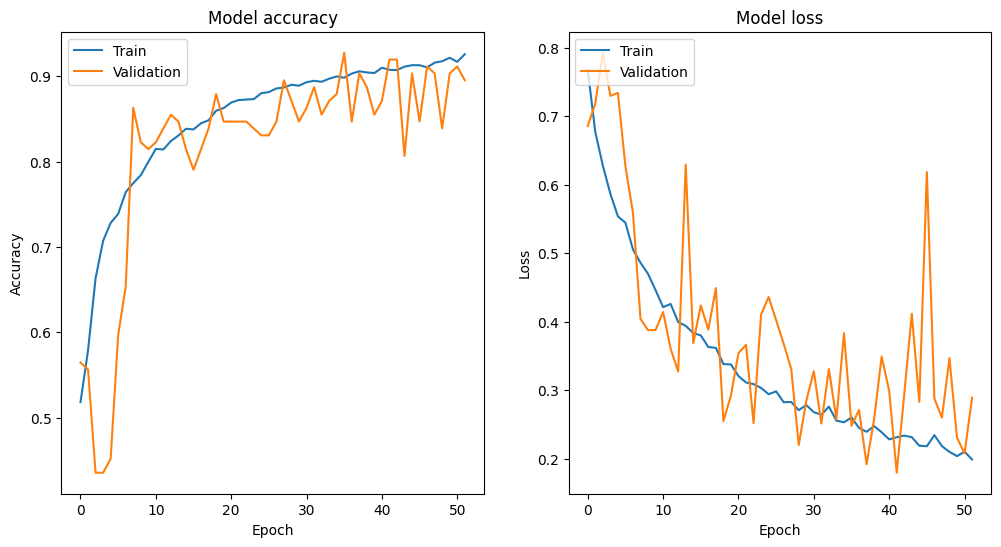

In [22]:
import matplotlib.pyplot as plt

# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_checkpoint_Resnet_2_final.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=200,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Plotting accuracy and loss graphs
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Abdelrahman_s/new_new/final_model_Resnet_2_final.h5')
model.save('final_model_Resnet_2_final.h5')
model.save('model_checkpoint_Resnet_2_final.h5')
model.save('/content/drive/MyDrive/Abdelrahman_s/new_new/model_checkpoint_Resnet_2_final.h5')


In [35]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

10/10 [==============================] - 6s 561ms/step - loss: 0.2020 - accuracy: 0.9219
Test accuracy: 92.19%


10/10 [==============================] - 6s 623ms/step


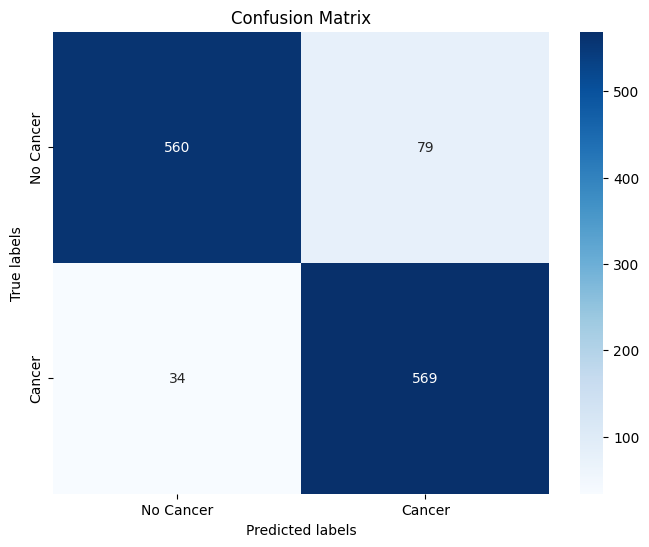

In [39]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Calculate confusion matrix
predictions = model.predict(test_generator)

# Get true labels
true_labels = test_generator.classes

# Convert predictions to class labels
predicted_labels = predictions.argmax(axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
cd '/content/drive/MyDrive/Abdelrahman_s/new_new/tensorboard_logs'


/content/drive/MyDrive/Abdelrahman_s/new_new/tensorboard_logs


In [ ]:
!tensorboard --logdir=.


2024-01-19 19:18:28.731852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 19:18:28.731922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 19:18:28.733473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 19:18:28.741495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 19:18:29.795890: W tensorflow/compiler/tf2

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Abdelrahman_s/new_new/tensorboard_logs


<IPython.core.display.Javascript object>

System architecture diagram saved as 'system_architecture.png'


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/final_model_Resnet_2.h5')


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the new images
image_paths = ['/content/image2.jpg', '/content/slide25.png','/content/slide13.png','/content/image.jpg']
new_images = []

for image_path in image_paths:
    img = load_img(image_path, target_size=(img_width, img_height))
    img = img_to_array(img)
    img = img / 255.0  # Rescale to the range [0, 1]
    new_images.append(img)

new_images = np.array(new_images)


In [ ]:
predictions = model.predict(new_images)
class_labels = train_generator.class_indices
predicted_labels = [list(class_labels.keys())[np.argmax(pred)] for pred in predictions]


1/1 [==============================] - 1s 1s/step


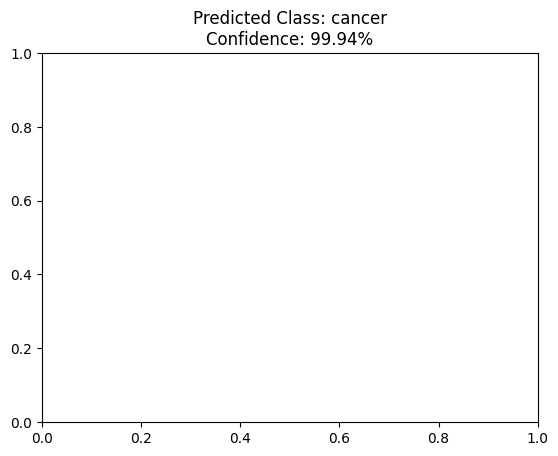

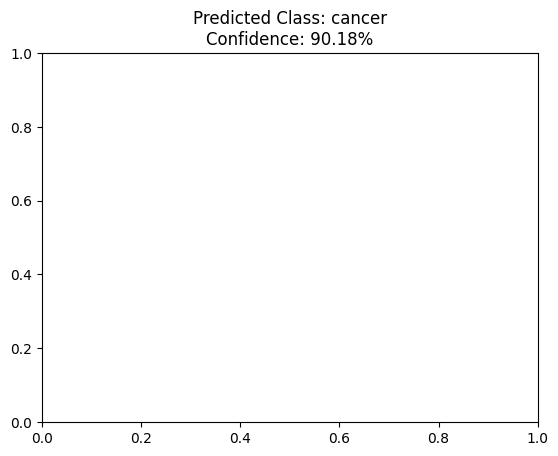

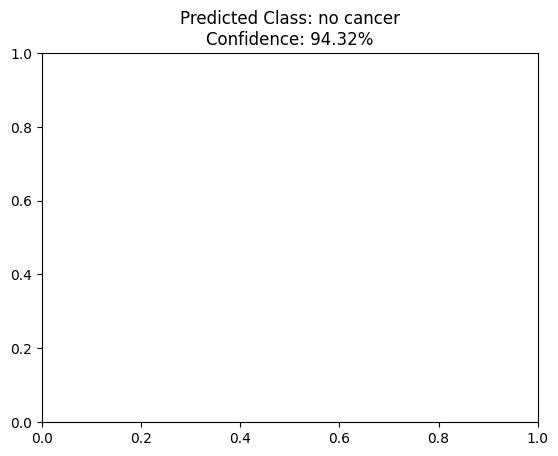

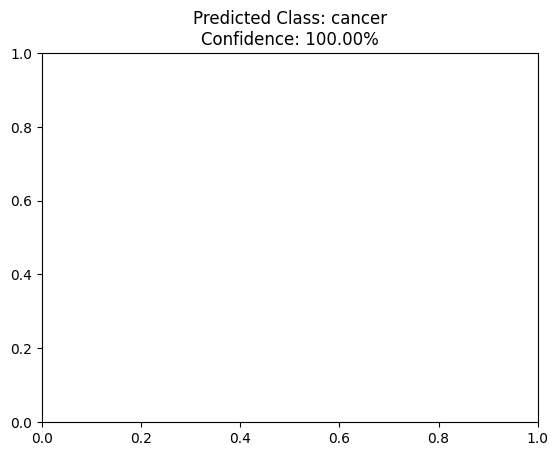

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(image_paths)):
    # Load the image
    img = load_img(image_paths[i], target_size=(img_width, img_height))
    #plt.figure()
    #plt.imshow(img)
    #plt.axis('off')

    # Display image information
    plt.title(f"Predicted Class: {predicted_labels[i]}\nConfidence: {predictions[i].max() * 100:.2f}%")
    plt.show()
